<a href="https://colab.research.google.com/github/ayoakin/MIVLDE/blob/LLMProbing/2D_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
!pip install numpy==1.25.2

In [76]:
%pip install torch==2.0.0
# Added because the default colab instance now has a newer version of colab
# This ended up breaking the following line below:
# dstr = SymbolicTransformerRegressor(from_pretrained=True)
# This is because PyTorch changed how it loads pickled files
!pip install odeformer

In [77]:
# give colab permission to access drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
# Update these as required
#repo_path = '/content/drive/MyDrive/github/subteams/LLMProbing'
repo_path = "/content/drive/MyDrive/Personlig/AISC Mech Interp Diff eq/MIVLDE/subteams/LLMProbing"
#odeformer_path = '/content/drive/MyDrive/aisc' # This is because I cloned the odeformer repo into my aisc folder
odeformer_path = '/content/drive/MyDrive'
#samples_path = '/content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/samples'
samples_path = '/content/drive/MyDrive/aisc/samples'
activations_path = '/content/drive/MyDrive/aisc/activations'
probes_path = '/content/drive/MyDrive/aisc/probes'

In [79]:
import sys
import importlib
sys.path.append(repo_path)
sys.path.append(odeformer_path)

In [80]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import linalg
from tqdm import tqdm
from tqdm.contrib import itertools

In [81]:
from odeformer.model import SymbolicTransformerRegressor
dstr = SymbolicTransformerRegressor(from_pretrained=True)

Found pretrained model at odeformer.pt
Loaded pretrained model


In [82]:
model_args = {'beam_size': 10, 'beam_temperature': 0.5}
dstr.set_model_args(model_args)

In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
times = np.linspace(0, 10, 50)
times_eval = np.linspace(110, 210, 500)
x_0 = 2.3 * np.cos(times + 0.5)
x_1 = 1.2 * np.sin(times + 0.1)
x_0_eval = 2.3 * np.cos(times_eval + 0.5)
x_1_eval = 1.2 * np.sin(times_eval + 0.1)
trajectory = np.stack([x_0, x_1], axis=1)  # (time, state) format
trajectory_eval = np.stack([x_0_eval, x_1_eval], axis=1)




In [89]:
candidates = dstr.fit(times, trajectory)
dstr.print(n_predictions=2)
#pred_trajectory = dstr.predict(times, trajectory[0])
pred_trajectory_eval = dstr.predict(times_eval, trajectory_eval[0])
#pred_trajectory = dstr.predict(times, 110)


# evaluating prediction using R2 score
from odeformer.metrics import r2_score
#print("R2 Score:", r2_score(trajectory, pred_trajectory))
print("R2 Score:", r2_score(trajectory_eval, pred_trajectory_eval))

x_0' = -0.2718 * x_0 + -2.0077 * x_1
x_1' = 0.5443 * x_0 + 0.2902 * x_1
x_0' = -0.2708 * x_0 + -1.9425 * x_1
x_1' = 0.5812 * x_0 + 0.2980 * x_1
R2 Score: 0.2792608870361351


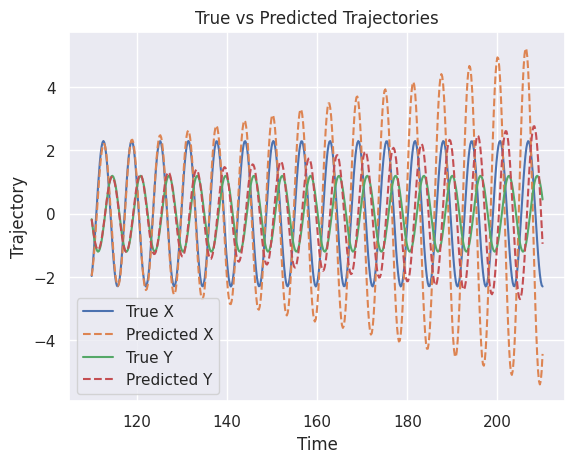

In [90]:
#plt.plot(times, trajectory[:, 0], label='True X')
plt.plot(times_eval, trajectory_eval[:, 0], label='True X')
#plt.plot(times, pred_trajectory[:, 0], label='Predicted X', linestyle='--')
plt.plot(times_eval, pred_trajectory_eval[:, 0], label='Predicted X', linestyle='--')
#plt.plot(times, trajectory[:, 1], label='True Y')
plt.plot(times_eval, trajectory_eval[:, 1], label='True Y')
#plt.plot(times, pred_trajectory[:, 1], label='Predicted Y', linestyle='--')
plt.plot(times_eval, pred_trajectory_eval[:, 1], label='Predicted Y', linestyle='--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Trajectory')
plt.title('True vs Predicted Trajectories')
plt.show()

x_0' = 0.0638 * x_1 + -0.5655 * x_0
x_1' = 3.4110 * x_0 + -3.8370 * x_1
x_0' = -0.5076 * x_1
x_1' = 0.6798 * x_0 + -1.2012 * x_1


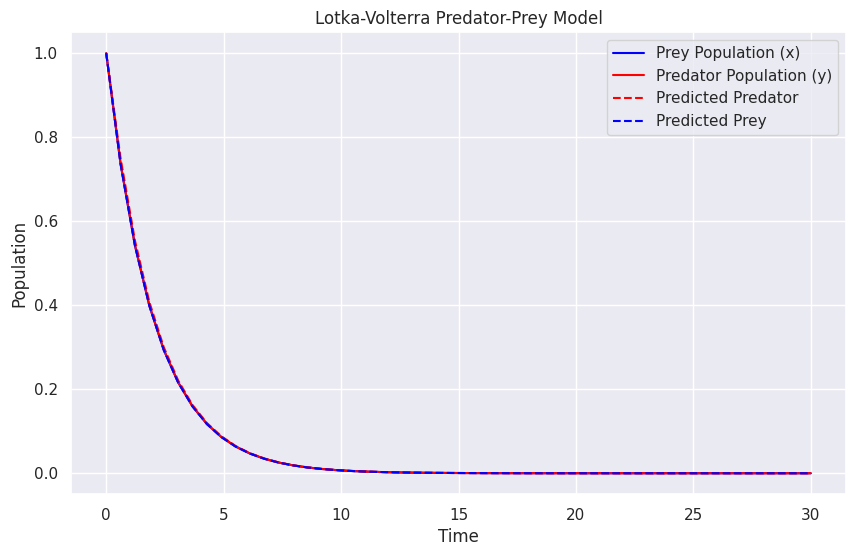

R2 Score:  0.9998787231605939


In [91]:
scale = 1
alpha = -1 * scale
beta = 0.5 * scale
gamma = 0.5 * scale
delta = -1 * scale


# Defining the system of ODEs
def lotka_volterra(t, z):
    x, y = z
    dxdt = alpha * x + beta * y
    dydt = gamma * x + delta * y
    return [dxdt, dydt]

# initial conditions
initial_conditions = [1, 1] # (with 40 prey and 9 predators)

# time span and points for the simulation
t_span = (0, 200)
t_points = np.linspace(0, 200, 1000)
t_points = np.linspace(0, 30, 50)

solution = solve_ivp(lotka_volterra, t_span, initial_conditions, t_eval=t_points)

# extracting prey and predator populations over time
prey = solution.y[0]
predator = solution.y[1]
trajectory = np.stack([prey, predator], axis=1)
candidates = dstr.fit(t_points, trajectory)
dstr.print(n_predictions=2)
pred_trajectory = dstr.predict(t_points, trajectory[0])

# plotting results
plt.figure(figsize=(10, 6))
plt.plot(t_points, prey, label='Prey Population (x)', color='blue')
plt.plot(t_points, predator, label='Predator Population (y)', color='red')
plt.title("Lotka-Volterra Predator-Prey Model")
plt.xlabel("Time")
plt.ylabel("Population")
plt.plot(t_points, pred_trajectory[:, 1], label='Predicted Predator', linestyle='--', color='red')
plt.plot(t_points, pred_trajectory[:, 0], label='Predicted Prey', linestyle='--', color='blue')
plt.legend()
plt.grid(True)
plt.show()
print("R2 Score: " ,r2_score(trajectory, pred_trajectory))

## Random Sample Generation

## Manual Sample Generation

In [33]:
# Times array
t_values = np.linspace(1, 10, 50)

# Exponential parameters
alpha_values = np.linspace(-1,1, 5)
beta_values = np.linspace(-1,1, 5)
gamma_values = np.linspace(-1,1, 5)
delta_values = np.linspace(-1,1, 5)
# Hyperbolic parameters
initial_conditions = [1,1]

In [28]:
 def clean_expression(expression):
    # In order to make expressions for equations easier to read
    cleaned = expression.replace('--', '')
    cleaned = cleaned.replace(' -', '-')
    cleaned = cleaned.replace('- ', '-')
    cleaned = cleaned.replace('+-', '-')
    return cleaned

In [29]:
def save_generated_samples(samples, template='sample_man_'):
    for idx, sample in tqdm(enumerate(samples), desc='Saving generated samples'):
        sample_filename = template + f"_{idx}.pt"
        sample_filepath = os.path.join(manual_samples_path, sample_filename)
        os.makedirs(os.path.dirname(sample_filepath), exist_ok=True)
        # Save file using pickle
        with open(sample_filepath, 'wb') as f:
          pickle.dump(sample, f)

In [50]:
dataset_name = '2D3'

In [51]:
manual_samples_path = samples_path + '/' + dataset_name

In [32]:
print(manual_samples_path)

/content/drive/MyDrive/aisc/samples/2D


In [42]:
alpha = -1.0
beta = -1.0
gamam = -1.0
delta = -0.5

def lotka_volterra(t, z):
  x, y = z
  dxdt = alpha * x + beta * y
  dydt = gamma * x + delta * y
  return [dxdt, dydt]


solution = solve_ivp(lotka_volterra, t_span, initial_conditions, t_eval=t_points)

x = solution.y[0]
y = solution.y[1]
trajectory = np.stack([x, y], axis=1)
candidates = dstr.fit(t_points, trajectory)
#print('dstr: ', dstr)
pred_trajectory = dstr.predict(t_points, trajectory[0])
print(trajectory)

[[ 1.00000000e+00  1.00000000e+00]
 [ 1.10820356e-01  8.62905339e-01]
 [-2.71303696e-01  6.03224597e-01]
 [-3.59181546e-01  3.55936640e-01]
 [-3.08746589e-01  1.72624704e-01]
 [-2.15250962e-01  5.83872574e-02]
 [-1.26696849e-01 -1.15468481e-03]
 [-6.12038175e-02 -2.46347444e-02]
 [-2.05142089e-02 -2.81414980e-02]
 [ 6.11787568e-04 -2.28519778e-02]
 [ 8.90116218e-03 -1.53052279e-02]
 [ 1.00929139e-02 -8.65210770e-03]
 [ 8.16789842e-03 -3.94032742e-03]
 [ 5.45965743e-03 -1.12190055e-03]
 [ 3.07726577e-03  2.73278469e-04]
 [ 1.39505806e-03  7.63261068e-04]
 [ 3.91739797e-04  7.77757445e-04]
 [-1.02969223e-04  5.98707754e-04]
 [-2.75227443e-04  3.84719487e-04]
 [-2.78928797e-04  2.07907828e-04]
 [-2.14064686e-04  8.76792938e-05]
 [-1.37393024e-04  1.90452536e-05]
 [-7.39264834e-05 -1.31905563e-05]
 [-3.10803907e-05 -2.29003782e-05]
 [-6.48790745e-06 -2.13112295e-05]
 [ 5.01462080e-06 -1.57047982e-05]
 [ 8.18843943e-06 -9.67802103e-06]
 [ 7.88854709e-06 -4.96799113e-06]
 [ 5.72255651e-06 -1

In [54]:
 def generate_2d_samples(t_values, alpha_values, beta_values, gamma_values, delta_values, is_performance_filter = False, performance_filter = -1):
    manual_samples = []
    for alpha in alpha_values:
        for beta in beta_values:
            for gamma in gamma_values:
                for delta in delta_values:
                    def lotka_volterra(t, z):
                      x, y = z
                      dxdt = alpha * x + beta * y
                      dydt = gamma * x + delta * y
                      return [dxdt, dydt]

                    solution = solve_ivp(lotka_volterra, t_span, initial_conditions, t_eval=t_points)
                    x = solution.y[0]
                    y = solution.y[1]
                    trajectory = np.stack([x, y], axis=1)
                    #candidates = dstr.fit(t_points, trajectory)
                    #print('dstr: ', dstr)
                    #pred_trajectory = dstr.predict(t_points, trajectory[0])
                    '''
                    if pred_trajectory is None:
                      print(alpha,beta,gamma,delta)
                      dstr.print(n_predictions = 2)
                      #print('trajectory: ', trajectory)
                      continue
                    '''
                    #r2 = r2_score(trajectory, pred_trajectory)
                    A = np.array([[alpha, beta],
                      [gamma, delta]])

                    # Calculate eigenvalues
                    eigenvalues = linalg.eigvals(A)
                    real_parts = np.real(eigenvalues)
                    imag_parts = np.imag(eigenvalues)
                    #print(eigenvalues[0])
                    #eigenv1 = eigenvalues[0]

                    #eigenv2 =
                    #if (is_performance_filter and r2 < performance_filter):
                        #continue
                    #print(alpha,beta,gamma,delta)
                    sample_dict = {
                        'times' : t_values,
                        'trajectory': trajectory,
                        'parameters': {'alpha': float(alpha), 'beta': float(beta), 'gamma': float(gamma), 'delta': float(delta)}, # Convert to float for better serialization
                        'feature_dict': {"real_0": real_parts[0],"real_1": real_parts[1], "imag_0": imag_parts[0], "imag_1" : imag_parts[1]},
                        'expression': clean_expression(f"dxdt = {alpha} * x + {beta} * y, dydt = {gamma} * x + {delta} * y")
                    }

                    manual_samples.append(sample_dict)


    save_generated_samples(manual_samples, template='sample_' + dataset_name)
    return 0
generate_2d_samples(t_values, alpha_values, beta_values, gamma_values, delta_values)

Saving generated samples: 625it [00:07, 89.10it/s]


0

In [55]:
from src.sample_generation import ManualSamplesGenerator

In [ ]:
#manual_samples_path = f'{samples_path}/demo_manual2'
manual_samples_path = f'{samples_path}/' + dataset_name
msg = ManualSamplesGenerator(samples_path=manual_samples_path)

In [ ]:
# Times array
t_values = np.linspace(1, 10, 50)

# Exponential parameters
c_values = np.linspace(-10,10, 2)
a_values = np.linspace(-10,10, 5)

# Hyperbolic parameters
t0_values = np.linspace(10.1, 100, 5)

In [ ]:
# Generate exponential samples
msg.generate_exponential_samples(t_values, c_values, a_values)

Generating exponential samples:   0%|          | 0/10 [00:00<?, ?it/s]

Saving generated samples: 10it [00:00, 57.64it/s]


[INFO] Data generation complete. Saved 10 exponential samples to /content/drive/MyDrive/aisc/samples/demo_manual_3


In [56]:
# Inspect an exponential sample to see its keys and some data
manual_samples_dir = os.fsencode(manual_samples_path)
for sample_file in os.listdir(manual_samples_dir):
  sample_name = os.fsdecode(sample_file)
  if "2D" in sample_name:
    exp_sample_path = os.path.join(manual_samples_path, sample_name)
    with open(exp_sample_path, 'rb') as f:
        exp_sample = pickle.load(f)
    print(exp_sample.keys())
    print(exp_sample['expression'])
    print(exp_sample['feature_dict'])
    #print(exp_sample['expression'])
    break

dict_keys(['times', 'trajectory', 'parameters', 'feature_dict', 'expression'])
dxdt =-1.0 * x -1.0 * y, dydt =-1.0 * x -1.0 * y
{'real_0': 0.0, 'real_1': -2.0, 'imag_0': 0.0, 'imag_1': 0.0}


## Corresponding Activations Extraction

In [43]:
from src.activation_extraction import ActivationsExtractor

In [57]:
random_activations_path = f'{activations_path}/demo_random3'
manual_activations_path = f'{activations_path}/{dataset_name}'

In [45]:
act_extractor = ActivationsExtractor()

In [ ]:
act_extractor.extract_activations(dstr, random_samples_path, random_activations_path, layers_to_extract=['ffn'])

Extracting Activations: 100%|██████████| 10/10 [00:28<00:00,  2.81s/it]


[INFO] Activation extraction complete. Activations saved to /content/drive/MyDrive/aisc/activations/demo_random3


In [58]:
act_extractor.extract_activations(dstr, manual_samples_path, manual_activations_path, layers_to_extract=['ffn'])

Extracting Activations:   0%|          | 2/625 [00:15<1:26:50,  8.36s/it]


nan in trajectory of sample 2D3_1


Extracting Activations:   5%|▌         | 34/625 [03:37<1:08:37,  6.97s/it]


nan in trajectory of sample 2D3_33


Extracting Activations:  15%|█▌        | 95/625 [10:27<1:11:06,  8.05s/it]


nan in trajectory of sample 2D3_94


Extracting Activations:  25%|██▌       | 158/625 [17:36<55:17,  7.10s/it]


nan in trajectory of sample 2D3_157


Extracting Activations:  34%|███▍      | 215/625 [23:17<55:02,  8.05s/it]


nan in trajectory of sample 2D3_214


Extracting Activations:  61%|██████    | 381/625 [43:11<32:49,  8.07s/it]


nan in trajectory of sample 2D3_380


Extracting Activations:  71%|███████   | 444/625 [52:33<26:58,  8.94s/it]


nan in trajectory of sample 2D3_443


Extracting Activations:  79%|███████▊  | 492/625 [59:28<21:55,  9.89s/it]


nan in trajectory of sample 2D3_491


Extracting Activations:  89%|████████▉ | 558/625 [1:10:18<12:31, 11.21s/it]


nan in trajectory of sample 2D3_557


Extracting Activations:  91%|█████████ | 567/625 [1:11:47<09:06,  9.42s/it]


nan in trajectory of sample 2D3_566


Extracting Activations: 100%|██████████| 625/625 [1:21:49<00:00,  7.85s/it]


[INFO] Activation extraction complete. Activations saved to /content/drive/MyDrive/aisc/activations/2D3


In [46]:
# Inspect a random activation and display its keys and some values
random_acts_dir = os.fsencode(random_activations_path)
for acts_file in os.listdir(random_acts_dir):
  acts_name = os.fsdecode(acts_file)
  random_acts_path = os.path.join(random_activations_path, acts_name)
  with open(random_acts_path, 'rb') as f:
      random_acts = pickle.load(f)
  print(random_acts.keys())
  print(random_acts['feature_dict'])
  #print(random_acts['r2_score'])
  print(random_acts['expression'])
  print(random_acts['pred_expression'])
  break

dict_keys(['encoder', 'decoder', 'operator_dict', 'feature_dict', 'pred_expression', 'expression'])
{'log': 0, 'exp': 0, 'tan': 0, 'arctan': 0, 'sin_cos': 0, 'arc_sin_cos': 0, 'pow2': 0, 'pow3': 0, 'inv': 0, 'sqrt': 0, 'r2_score': 0.9999999755587363}
-0.9998 * x_0
x_0' = -1.0000000000000000 * x_0



In [59]:
# Inspect a manual activation and display its keys and some values
manual_acts_dir = os.fsencode(manual_activations_path)
for acts_file in os.listdir(manual_acts_dir):
  acts_name = os.fsdecode(acts_file)
  manual_acts_path = os.path.join(manual_activations_path, acts_name)
  with open(manual_acts_path, 'rb') as f:
      manual_acts = pickle.load(f)
  print(manual_acts.keys())
  print(manual_acts['feature_dict'])
  #print(manual_acts['r2_score'])
  print(manual_acts['expression'])
  print(manual_acts['pred_expression'])
  break

dict_keys(['encoder', 'decoder', 'feature_dict', 'pred_expression', 'expression'])
{'real_0': 0.0, 'real_1': -2.0, 'imag_0': 0.0, 'imag_1': 0.0, 'r2_score': 0.999903635525919}
dxdt =-1.0 * x -1.0 * y, dydt =-1.0 * x -1.0 * y
x_0' = -6.7740 * x_0
x_1' = 0.1897 * x_0 + -7.0580 * x_1



## Probe Training

In [92]:
import experiments

In [61]:
dir(experiments)
# Current experiment functions supported:
#   - separability_testing

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'r2_prediction_experiment',
 'run_experiment',
 'separability_testing']

In [129]:
target_feature = 'real_1'
activations_path = manual_activations_path
demo_probes_path = f'{probes_path}/{dataset_name}/real_1'
lr = 0.01
num_epochs = 50
num_repeats = 1
layers = [idx for idx in range(16)]

In [130]:


demo_expt_results = experiments.separability_testing(target_feature=target_feature, activations_path=manual_activations_path, \
                     probes_path=demo_probes_path, \
                     lr=lr, num_epochs=num_epochs, \
                     layers=layers, num_repeats=num_repeats)

Repeat 0 of layer 0


KeyboardInterrupt: 

In [ ]:
expt_results = experiments.scalar_prediction_experiment(target_feature=target_feature, activations_path=manual_activations_path, \
                     probes_path=demo_probes_path, \
                     lr=lr, num_epochs=num_epochs, \
                     layers=layers, num_repeats=num_repeats)
# save experiment results
with open(f'{demo_probes_path}/experiment_data.pt', 'wb') as f:
    pickle.dump(expt_results, f)

Repeat 0 of layer 0



Training LR Probe:  38%|███▊      | 19/50 [01:21<02:13,  4.31s/it]

In [110]:
expt_results

,layer,run,test_loss,final_train_loss,final_val_loss
0,0,0,54.571992,6.118677,142.718837
1,1,0,207.978291,33.811070,285.845791
2,2,0,857.645282,25.739553,315.479900
3,3,0,56.916670,6.487603,41.283610
4,4,0,1.666486,0.936969,15.433470
5,5,0,0.122432,0.152436,1.977946
6,6,0,0.078865,0.005546,0.090992
7,7,0,0.077120,0.003918,0.074523
8,8,0,0.296642,0.003423,0.213766
9,9,0,0.133659,0.002524,0.159806


In [106]:
demo_expt_results

,layer,run,test_loss,test_accuracy,test_fail_ids,final_train_loss,final_train_accuracy,final_val_loss,final_val_accuracy
0,0,0,-67.409128,0.096774,"[2D3_253, 2D3_102, 2D3_198, 2D3_216, 2D3_334, ...",-1.262190,0.119760,-25.789954,0.112903
1,0,1,-76.395791,0.096774,"[2D3_249, 2D3_49, 2D3_18, 2D3_184, 2D3_291, 2D...",-1.713139,0.131737,-32.629442,0.112903
2,1,0,-63.822525,0.096774,"[2D3_61, 2D3_28, 2D3_603, 2D3_606, 2D3_216, 2D...",-1.197552,0.119760,-33.992997,0.112903
3,1,1,-67.414984,0.096774,"[2D3_139, 2D3_603, 2D3_24, 2D3_249, 2D3_41, 2D...",-1.441485,0.113772,-37.029507,0.112903
4,2,0,-38.388914,0.096774,"[2D3_105, 2D3_85, 2D3_167, 2D3_411, 2D3_522, 2...",-0.492024,0.121756,-16.754091,0.129032
5,2,1,-49.096033,0.096774,"[2D3_522, 2D3_198, 2D3_305, 2D3_10, 2D3_28, 2D...",-0.667256,0.121756,-21.620750,0.129032
6,3,0,-34.388168,0.096774,"[2D3_622, 2D3_49, 2D3_291, 2D3_603, 2D3_606, 2...",0.520310,0.119760,-7.810927,0.112903
7,3,1,-30.887577,0.096774,"[2D3_64, 2D3_13, 2D3_249, 2D3_473, 2D3_468, 2D...",0.236160,0.113772,-8.349448,0.112903
8,4,0,-43.023142,0.096774,"[2D3_13, 2D3_105, 2D3_102, 2D3_237, 2D3_416, 2...",-0.788327,0.135729,-13.191764,0.129032
9,4,1,-47.835382,0.096774,"[2D3_473, 2D3_603, 2D3_407, 2D3_49, 2D3_483, 2...",-0.918615,0.141717,-14.488637,0.096774


In [113]:
import experiments.utils as expt_utils

demo_expt_summary = expt_utils.summarise_experiment(demo_expt_results)

expt_summary = expt_utils.summarise_experiment(expt_results)

In [117]:
expt_summary_old = expt_summary


In [125]:
expt_summary = expt_summary_old[0:4]

In [126]:
expt_summary

,layer,loss_mean,loss_std
0,0,54.571992,NaN
1,1,207.978291,NaN
2,2,857.645282,NaN
3,3,56.916670,NaN


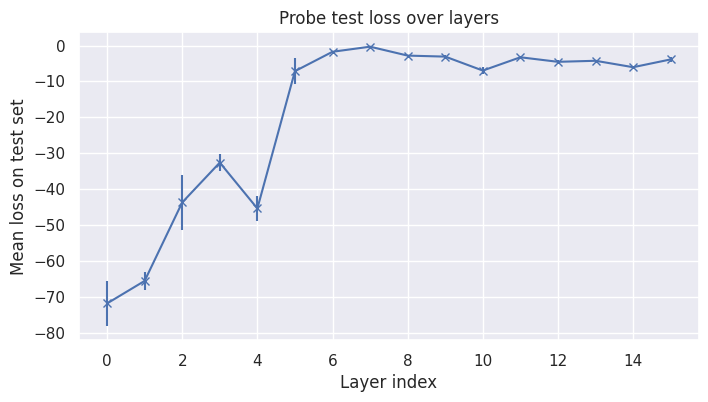

In [127]:
expt_utils.plot_from_summary(demo_expt_summary, descriptor='demo')

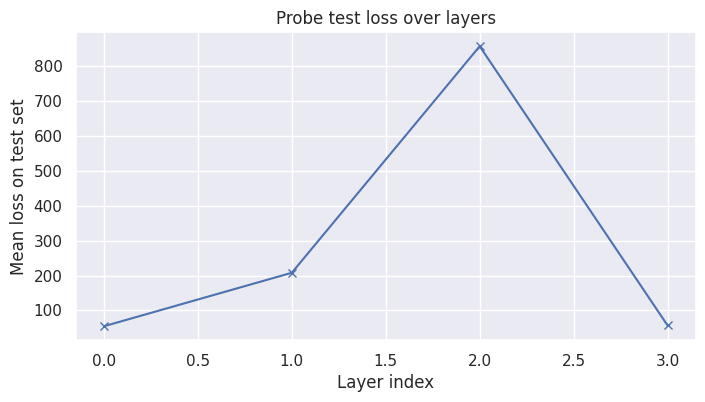

In [128]:
expt_utils.plot_from_summary(expt_summary, descriptor='demo')

## Probe Loading and Evaluation

In [ ]:
# TODO: write extra loading functionality for running an experiment using pretrained
# TODO: extend failure detection functionality